In [39]:
from Helper.ml_models import * 
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks
import numpy as np
import pandas as pd

index = 0


# Initializing Model and Dataset + Data Leak Check

In [40]:
model = TrainedModel('deeplabv3_resnet101',
                     2048,
                     1024,
                     'deeplabv3_resnet101_k_fold_4',
                     folder_path='K_Fold_Run',
                     start_epoch='latest')

k_fold_dataset = K_Fold_Dataset(image_dir='CityscapesDaten/images',
                                            annotation_dir='CityscapesDaten/semantic',
                                            k_fold_csv_dir='Daten/CityscapesDaten',
                                            leave_out_fold=0)

k_fold_dataset.check_for_data_leaks()  

Using CUDA GPU
Model loaded: deeplabv3_resnet101 | Device: cuda 
own lrs: 1e-05
No data leaks found.


In [41]:
image, annotation = k_fold_dataset.train_dataset[index]

print(f'Image shape: {image.shape}, Annotation shape: {annotation.shape}')
print(f'Annotation Value range: {np.unique(annotation)}')

Image shape: torch.Size([3, 520, 520]), Annotation shape: torch.Size([520, 520])
Annotation Value range: [ 0  1  2  4  5  7  8  9 10 11 13 19]


In [42]:
model.prepare_model_training(
    dataset_train=k_fold_dataset.train_dataset,
    dataset_val=k_fold_dataset.val_dataset,
    dataset_test=k_fold_dataset.test_dataset,
    batch_size=2, 
    shuffle=True,
    learning_rate=1e-5,
    num_workers=4,
    pin_memory=True
)

Training Dataset prepared
Validation Dataset prepared
Test Dataset prepared
own lrs: 1e-08


# Inferenz 

In [43]:
# Inferenz durchführen
output = model.inference(image)

# Vorhersage extrahieren
predicted = output.argmax(1).squeeze(0)  # Shape: (H, W)


In [44]:
# Mittelwert und Standardabweichung aus dem Datensatz
mean = torch.tensor(k_fold_dataset.test_dataset.mean).view(3, 1, 1)
std = torch.tensor(k_fold_dataset.test_dataset.std).view(3, 1, 1)

# Bild zurücknormalisieren
image_unnorm = image * std + mean
image_unnorm = (image_unnorm * 255).type(torch.uint8)


In [45]:
# Alles auf die CPU verschieben
image_unnorm = image_unnorm.cpu()
predicted = predicted.cpu()
annotation = annotation.cpu()


In [46]:
# Anzahl der Klassen
num_classes = model.num_classes

# Masken für die Annotation erstellen
annotation_masks = annotation == torch.arange(num_classes).unsqueeze(1).unsqueeze(2)

# Masken für die Vorhersage erstellen
predicted_masks = predicted == torch.arange(num_classes).unsqueeze(1).unsqueeze(2)


In [47]:
# Masken in boolesche Tensors konvertieren
annotation_masks = annotation_masks.type(torch.bool)
predicted_masks = predicted_masks.type(torch.bool)


In [48]:
# Farben für die Klassen (aus dem Modell)
colors = model.city_label_color_map

# Bild mit der Annotation überlagern
image_with_annotation = draw_segmentation_masks(image_unnorm, annotation_masks, alpha=0.5, colors=colors)

# Bild mit der Vorhersage überlagern
image_with_prediction = draw_segmentation_masks(image_unnorm, predicted_masks, alpha=0.5, colors=colors)


In [49]:
# Dimensionen permutieren und in NumPy-Arrays konvertieren
image_with_annotation_np = image_with_annotation.permute(1, 2, 0).numpy()
image_with_prediction_np = image_with_prediction.permute(1, 2, 0).numpy()


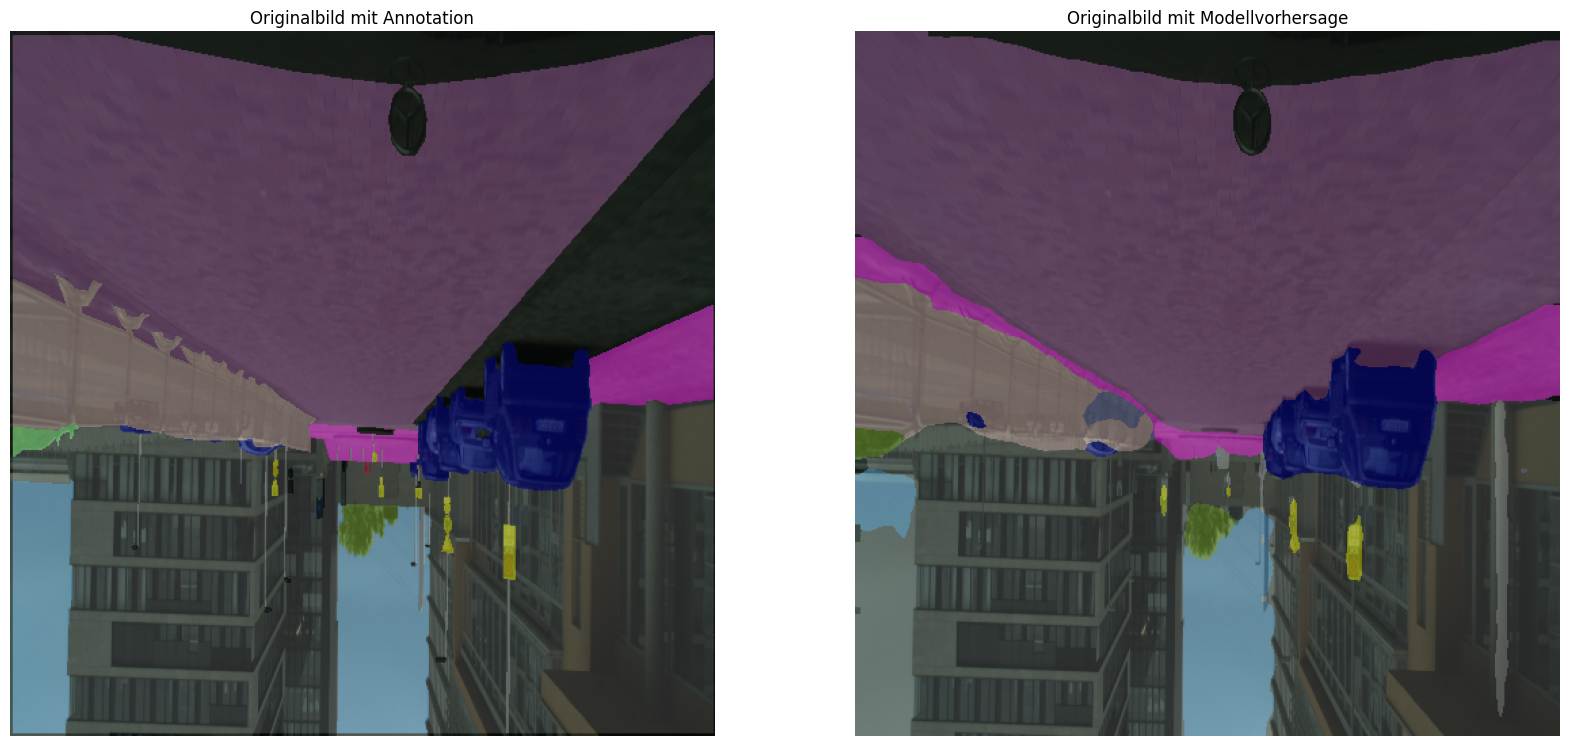

In [50]:
# Figuren und Achsen erstellen
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Linkes Bild: Original mit Annotation
axes[0].imshow(image_with_annotation_np)
axes[0].set_title('Originalbild mit Annotation')
axes[0].axis('off')

# Rechtes Bild: Original mit Vorhersage
axes[1].imshow(image_with_prediction_np)
axes[1].set_title('Originalbild mit Modellvorhersage')
axes[1].axis('off')

# Anzeigen der Bilder
plt.show()


# Metriken einzel Bild


In [51]:
# ACCURACY Metric 1

def compute_confusion_matrix(predicted, ground_truth, num_classes):
    mask = (ground_truth >= 0) & (ground_truth < num_classes)
    label = num_classes * ground_truth[mask] + predicted[mask]
    count = torch.bincount(label, minlength=num_classes**2)
    confusion_matrix = count.reshape(num_classes, num_classes)
    return confusion_matrix

def compute_miou(confusion_matrix):
    intersection = torch.diag(confusion_matrix)
    ground_truth_set = confusion_matrix.sum(1)
    predicted_set = confusion_matrix.sum(0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / (union + 1e-6)  # Kleine Konstante, um Division durch Null zu vermeiden
    mIoU = torch.mean(IoU)
    return mIoU.item(), IoU

def compute_mean_pixel_accuracy(confusion_matrix):
    true_positive = torch.diag(confusion_matrix)
    total_pixels = confusion_matrix.sum(1)
    pixel_accuracy = true_positive / (total_pixels + 1e-6)
    mPA = torch.mean(pixel_accuracy)
    return mPA.item(), pixel_accuracy

def compute_fwiou(confusion_matrix):
    total_pixels = confusion_matrix.sum()
    ground_truth_set = confusion_matrix.sum(1)
    intersection = torch.diag(confusion_matrix)
    union = ground_truth_set + confusion_matrix.sum(0) - intersection
    IoU = intersection / (union + 1e-6)
    FWIoU = (ground_truth_set * IoU) / total_pixels
    FWIoU = FWIoU.sum()
    return FWIoU.item()

def compute_dice_coefficient(confusion_matrix):
    intersection = torch.diag(confusion_matrix)
    ground_truth_set = confusion_matrix.sum(1)
    predicted_set = confusion_matrix.sum(0)
    dice = (2 * intersection) / (ground_truth_set + predicted_set + 1e-6)
    mean_dice = torch.mean(dice)
    return mean_dice.item(), dice

# Konfusionsmatrix berechnen
conf_matrix = compute_confusion_matrix(predicted, annotation, num_classes)

# Mean IoU berechnen
miou, per_class_iou = compute_miou(conf_matrix)
print(f"Mean IoU: {miou}")

# Mean Pixel Accuracy berechnen
mpa, per_class_pa = compute_mean_pixel_accuracy(conf_matrix)
print(f"Mean Pixel Accuracy: {mpa}")

# Frequency Weighted IoU berechnen
fwiou = compute_fwiou(conf_matrix)
print(f"Frequency Weighted IoU: {fwiou}")

# Dice-Koeffizient berechnen
mean_dice, per_class_dice = compute_dice_coefficient(conf_matrix)
print(f"Mean Dice Coefficient: {mean_dice}")

# Per-Klassen IoU anzeigen
print("Per-Klassen IoU:")
for idx, iou in enumerate(per_class_iou):
    print(f"Klasse {idx}: IoU = {iou.item()}")

# Per-Klassen Dice-Koeffizient anzeigen
print("Per-Klassen Dice-Koeffizient:")
for idx, dice in enumerate(per_class_dice):
    print(f"Klasse {idx}: Dice-Koeffizient = {dice.item()}")

# Per-Klassen Pixel Accuracy anzeigen
print("Per-Klassen Pixel Accuracy:")
for idx, pa in enumerate(per_class_pa):
    print(f"Klasse {idx}: Pixel Accuracy = {pa.item()}")



Mean IoU: 0.2977941930294037
Mean Pixel Accuracy: 0.3602035939693451
Frequency Weighted IoU: 0.744888186454773
Mean Dice Coefficient: 0.3530223071575165
Per-Klassen IoU:
Klasse 0: IoU = 0.8058241605758667
Klasse 1: IoU = 0.6129538416862488
Klasse 2: IoU = 0.8607204556465149
Klasse 3: IoU = 0.0
Klasse 4: IoU = 0.8041309118270874
Klasse 5: IoU = 0.019420376047492027
Klasse 6: IoU = 0.0
Klasse 7: IoU = 0.5063414573669434
Klasse 8: IoU = 0.5131649374961853
Klasse 9: IoU = 0.0
Klasse 10: IoU = 0.5796558856964111
Klasse 11: IoU = 0.0
Klasse 12: IoU = 0.0
Klasse 13: IoU = 0.9020392298698425
Klasse 14: IoU = 0.0
Klasse 15: IoU = 0.0
Klasse 16: IoU = 0.0
Klasse 17: IoU = 0.0
Klasse 18: IoU = 0.0
Klasse 19: IoU = 0.3516327440738678
Per-Klassen Dice-Koeffizient:
Klasse 0: Dice-Koeffizient = 0.8924724459648132
Klasse 1: Dice-Koeffizient = 0.7600389122962952
Klasse 2: Dice-Koeffizient = 0.9251474738121033
Klasse 3: Dice-Koeffizient = 0.0
Klasse 4: Dice-Koeffizient = 0.8914330005645752
Klasse 5: Dic

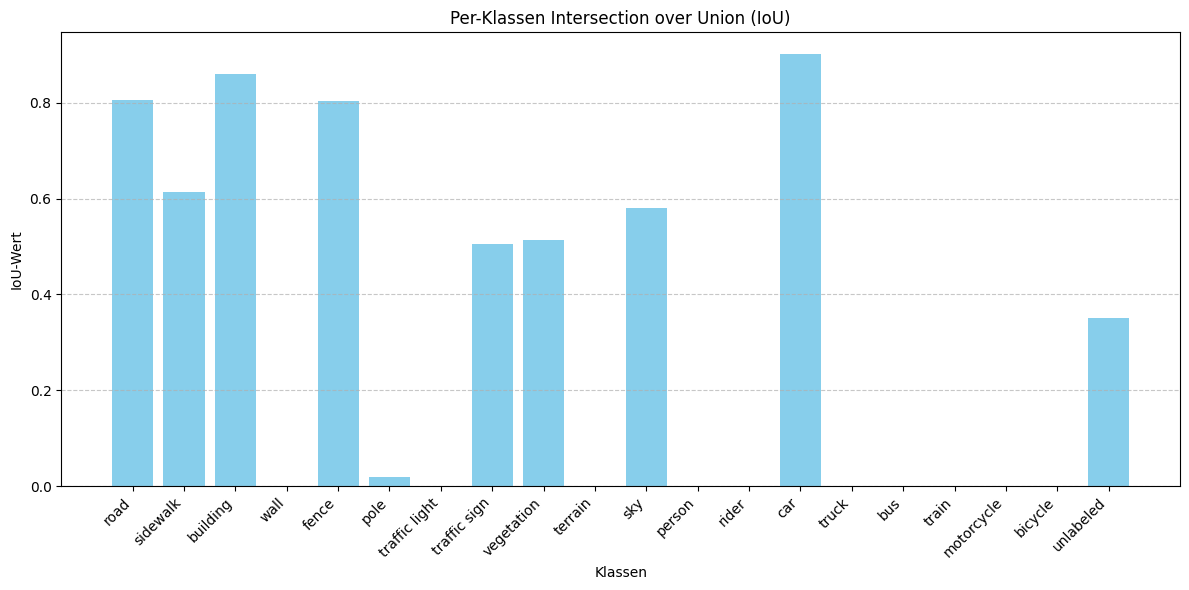

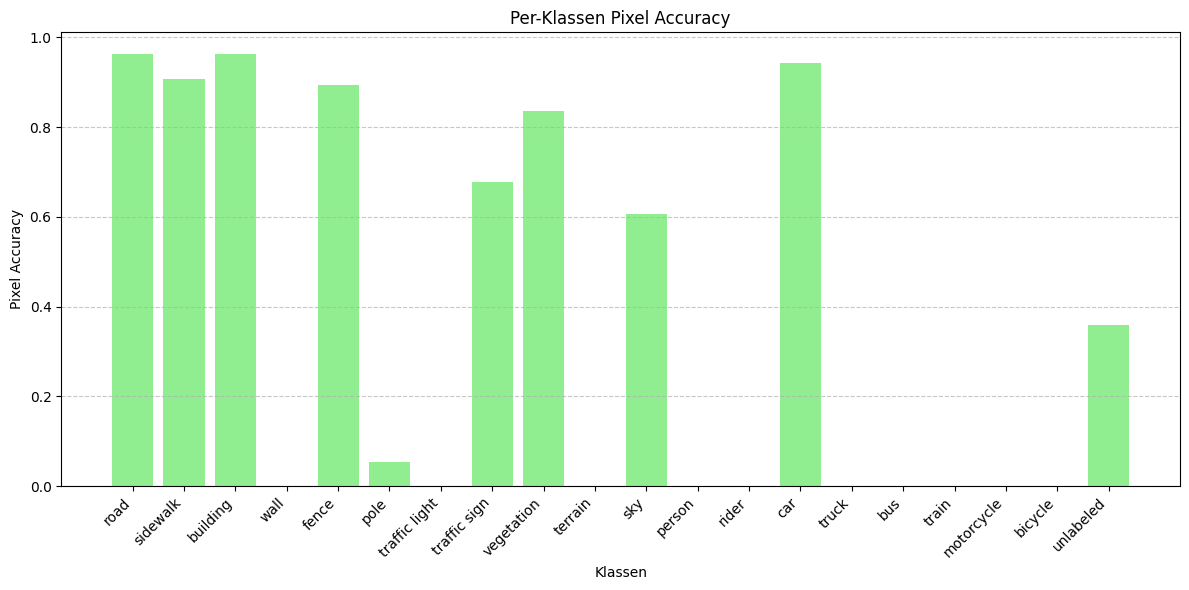

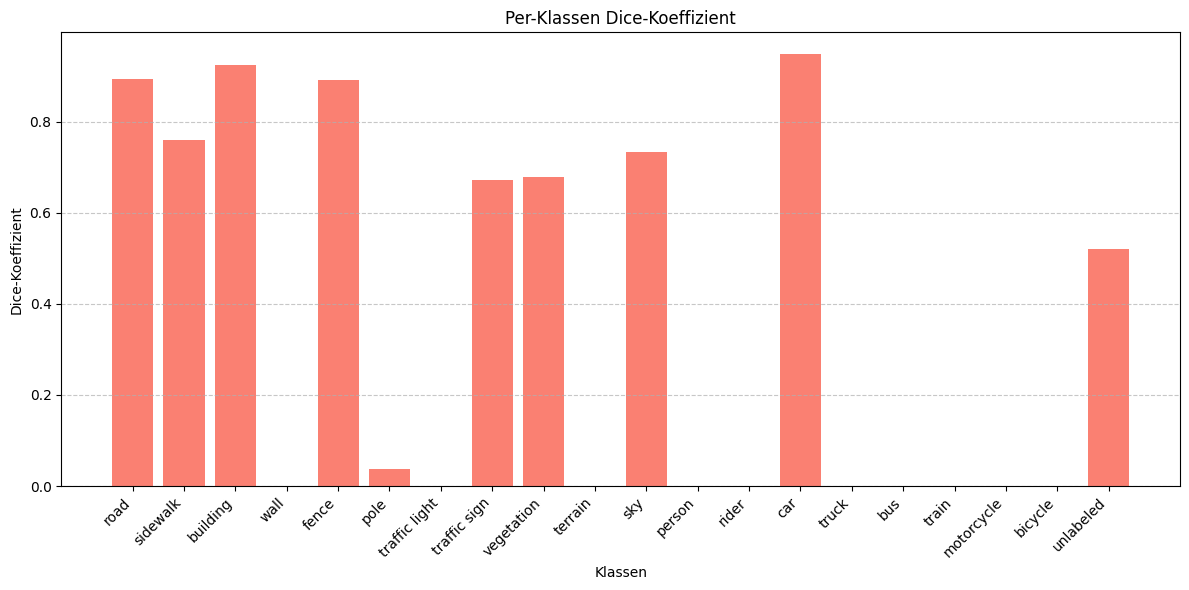

Gesamtmetriken:
Mean IoU: 0.2978
Mean Pixel Accuracy: 0.3602
Frequency Weighted IoU: 0.7449
Mean Dice Coefficient: 0.3530

Gesamtmetriken Tabelle:
                Metric    Value
              Mean IoU 0.297794
   Mean Pixel Accuracy 0.360204
Frequency Weighted IoU 0.744888
 Mean Dice Coefficient 0.353022


In [52]:
# ACCURACY METRIC 2


# Klassennamen definieren
class_names = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic light', 'traffic sign', 'vegetation', 'terrain',
    'sky', 'person', 'rider', 'car', 'truck', 'bus',
    'train', 'motorcycle', 'bicycle', 'unlabeled'
]

# Sicherstellen, dass die Anzahl der Klassennamen stimmt
assert len(class_names) == num_classes, "Die Anzahl der Klassennamen stimmt nicht mit der Anzahl der Klassen überein."

# Konvertieren der Per-Klassen-Metriken zu NumPy-Arrays
per_class_iou_np = per_class_iou.cpu().numpy()
per_class_pa_np = per_class_pa.cpu().numpy()
per_class_dice_np = per_class_dice.cpu().numpy()

# Per-Klassen IoU plotten
plt.figure(figsize=(12, 6))
plt.bar(range(num_classes), per_class_iou_np, tick_label=class_names, color='skyblue')
plt.title('Per-Klassen Intersection over Union (IoU)')
plt.xlabel('Klassen')
plt.ylabel('IoU-Wert')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Per-Klassen Pixel Accuracy plotten
plt.figure(figsize=(12, 6))
plt.bar(range(num_classes), per_class_pa_np, tick_label=class_names, color='lightgreen')
plt.title('Per-Klassen Pixel Accuracy')
plt.xlabel('Klassen')
plt.ylabel('Pixel Accuracy')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Per-Klassen Dice-Koeffizient plotten
plt.figure(figsize=(12, 6))
plt.bar(range(num_classes), per_class_dice_np, tick_label=class_names, color='salmon')
plt.title('Per-Klassen Dice-Koeffizient')
plt.xlabel('Klassen')
plt.ylabel('Dice-Koeffizient')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gesamtmetriken anzeigen
print("Gesamtmetriken:")
print(f"Mean IoU: {miou:.4f}")
print(f"Mean Pixel Accuracy: {mpa:.4f}")
print(f"Frequency Weighted IoU: {fwiou:.4f}")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")

# Gesamtmetriken in einer Tabelle darstellen
metrics_data = {
    'Metric': ['Mean IoU', 'Mean Pixel Accuracy', 'Frequency Weighted IoU', 'Mean Dice Coefficient'],
    'Value': [miou, mpa, fwiou, mean_dice]
}

metrics_df = pd.DataFrame(metrics_data)
print("\nGesamtmetriken Tabelle:")
print(metrics_df.to_string(index=False))


# Metriken TEST Datensatz

Evaluating: 100%|██████████| 695/695 [01:13<00:00,  9.47it/s]


Gesamtmetriken:
Mean IoU: 0.5863
Mean Pixel Accuracy: 0.7325
Frequency Weighted IoU: 0.8247
Mean Dice Coefficient: 0.7197


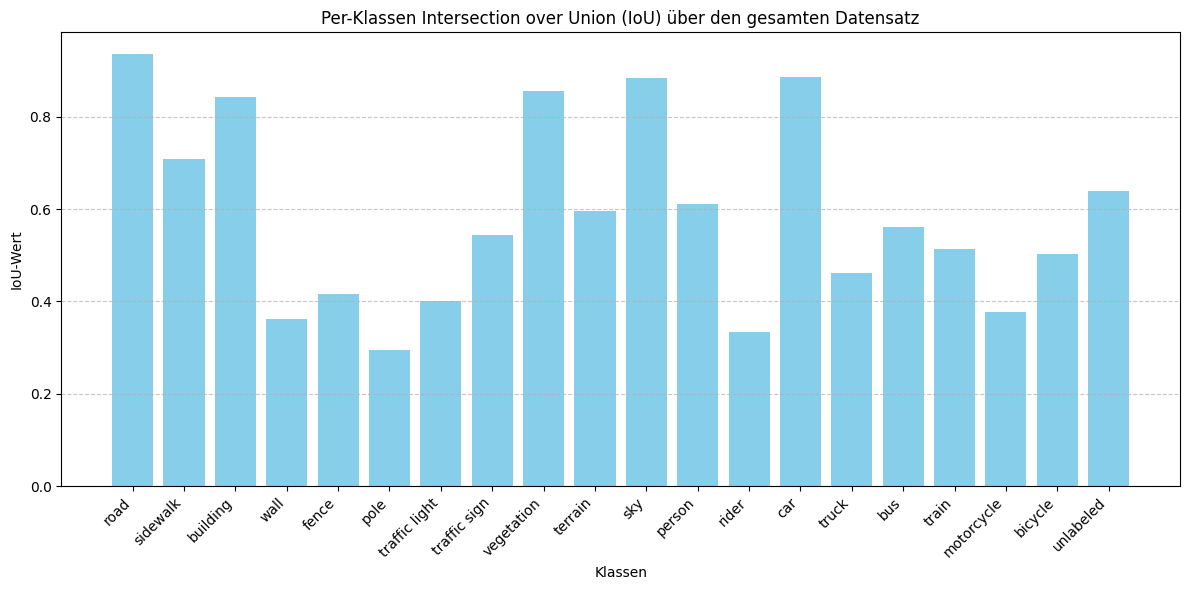

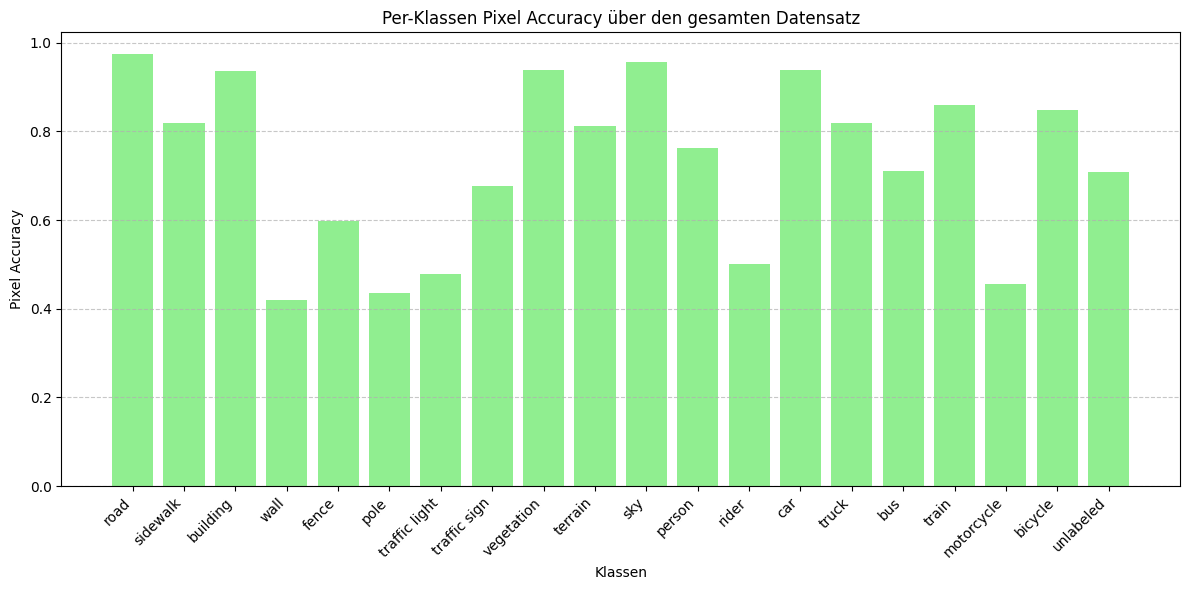

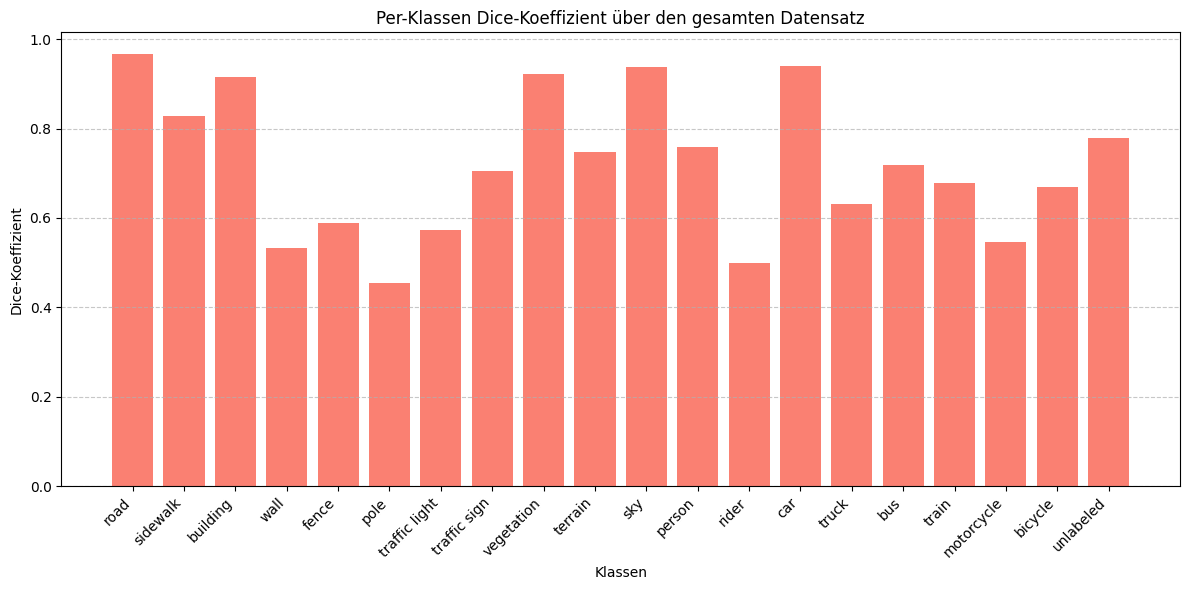


Gesamtmetriken Tabelle:
                Metric    Value
              Mean IoU 0.586330
   Mean Pixel Accuracy 0.732549
Frequency Weighted IoU 0.824669
 Mean Dice Coefficient 0.719698


In [53]:
# Metrik Test Datensatz

from tqdm import tqdm

# Anzahl der Klassen
num_classes = model.num_classes

# Klassennamen definieren
class_names = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic light', 'traffic sign', 'vegetation', 'terrain',
    'sky', 'person', 'rider', 'car', 'truck', 'bus',
    'train', 'motorcycle', 'bicycle', 'unlabeled'
]

# Konfusionsmatrix initialisieren
confusion_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int64)

# Modell in den Evaluationsmodus setzen
model.model.eval()

# Evaluierung starten
with torch.no_grad():
    for i in tqdm(range(len(k_fold_dataset.test_dataset)), desc='Evaluating'):
        # Bild und Annotation laden
        image, annotation = k_fold_dataset.test_dataset[i]
        
        # Inferenz durchführen
        output = model.inference(image)
        predicted = output.argmax(1).squeeze(0)
        
        # Konfusionsmatrix aktualisieren
        conf_matrix = compute_confusion_matrix(predicted.cpu(), annotation.cpu(), num_classes)
        confusion_matrix += conf_matrix

# Metriken berechnen
miou, per_class_iou = compute_miou(confusion_matrix)
mpa, per_class_pa = compute_mean_pixel_accuracy(confusion_matrix)
fwiou = compute_fwiou(confusion_matrix)
mean_dice, per_class_dice = compute_dice_coefficient(confusion_matrix)

# Gesamtmetriken anzeigen
print("Gesamtmetriken:")
print(f"Mean IoU: {miou:.4f}")
print(f"Mean Pixel Accuracy: {mpa:.4f}")
print(f"Frequency Weighted IoU: {fwiou:.4f}")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")

# Metriken in NumPy-Arrays konvertieren
per_class_iou_np = per_class_iou.cpu().numpy()
per_class_pa_np = per_class_pa.cpu().numpy()
per_class_dice_np = per_class_dice.cpu().numpy()

# Per-Klassen IoU plotten
plt.figure(figsize=(12, 6))
plt.bar(range(num_classes), per_class_iou_np, tick_label=class_names, color='skyblue')
plt.title('Per-Klassen Intersection over Union (IoU) über den gesamten Datensatz')
plt.xlabel('Klassen')
plt.ylabel('IoU-Wert')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Per-Klassen Pixel Accuracy plotten
plt.figure(figsize=(12, 6))
plt.bar(range(num_classes), per_class_pa_np, tick_label=class_names, color='lightgreen')
plt.title('Per-Klassen Pixel Accuracy über den gesamten Datensatz')
plt.xlabel('Klassen')
plt.ylabel('Pixel Accuracy')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Per-Klassen Dice-Koeffizient plotten
plt.figure(figsize=(12, 6))
plt.bar(range(num_classes), per_class_dice_np, tick_label=class_names, color='salmon')
plt.title('Per-Klassen Dice-Koeffizient über den gesamten Datensatz')
plt.xlabel('Klassen')
plt.ylabel('Dice-Koeffizient')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gesamtmetriken in einer Tabelle darstellen
metrics_data = {
    'Metric': ['Mean IoU', 'Mean Pixel Accuracy', 'Frequency Weighted IoU', 'Mean Dice Coefficient'],
    'Value': [miou, mpa, fwiou, mean_dice]
}

metrics_df = pd.DataFrame(metrics_data)
print("\nGesamtmetriken Tabelle:")
print(metrics_df.to_string(index=False))


Evaluating: 100%|██████████| 695/695 [01:08<00:00, 10.10it/s]


Gesamtmetriken:
Mean IoU: 0.5863
Mean Pixel Accuracy: 0.7325
Frequency Weighted IoU: 0.8247
Mean Dice Coefficient: 0.7197


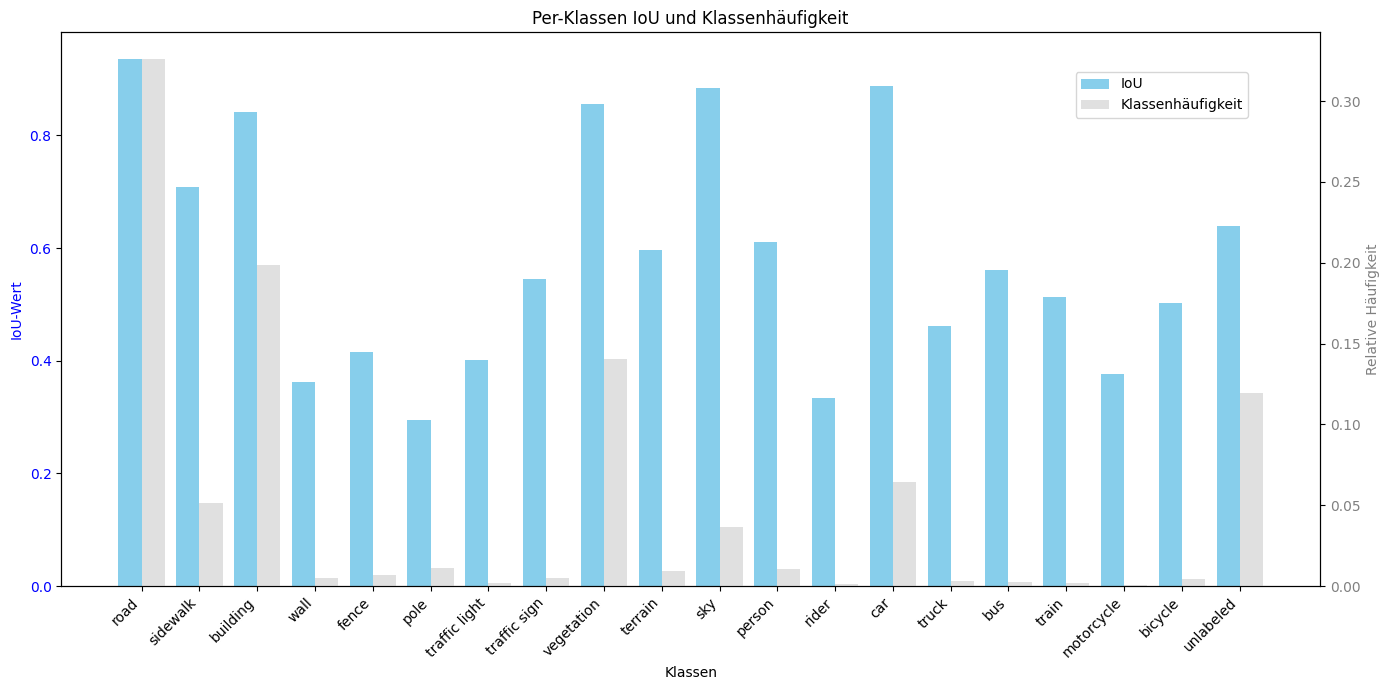

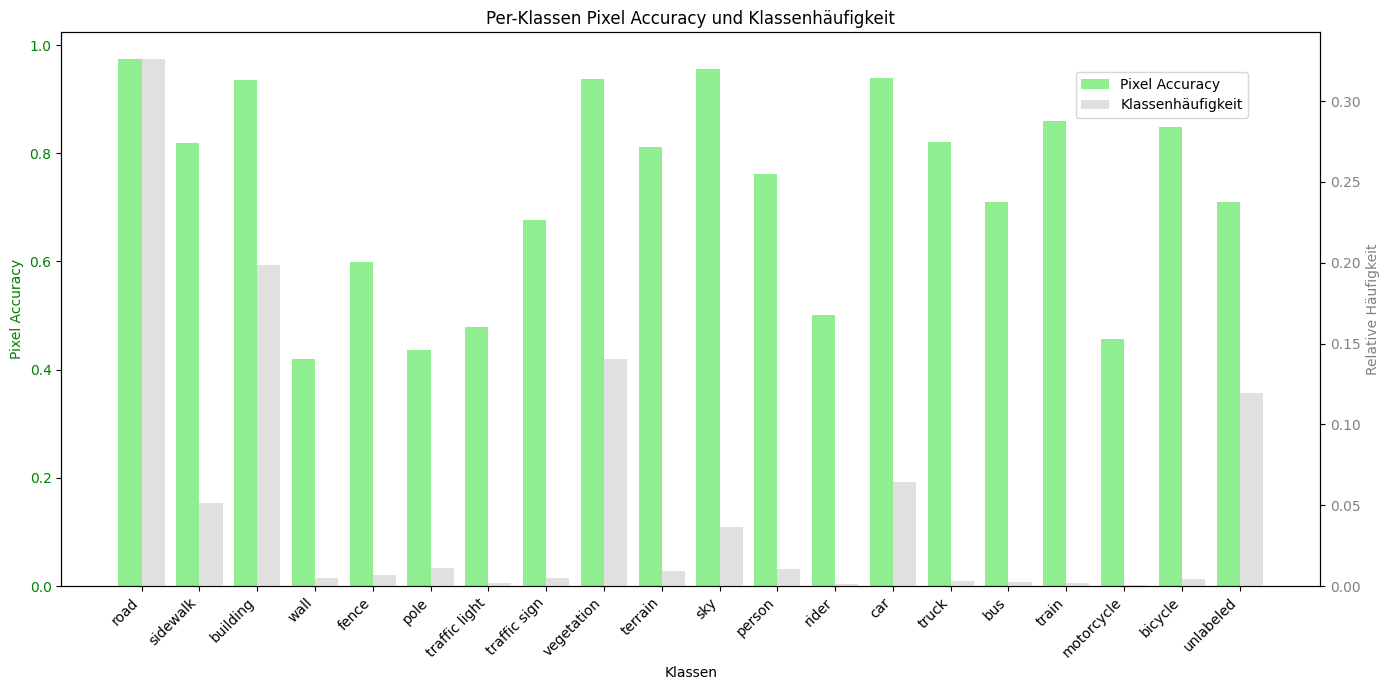

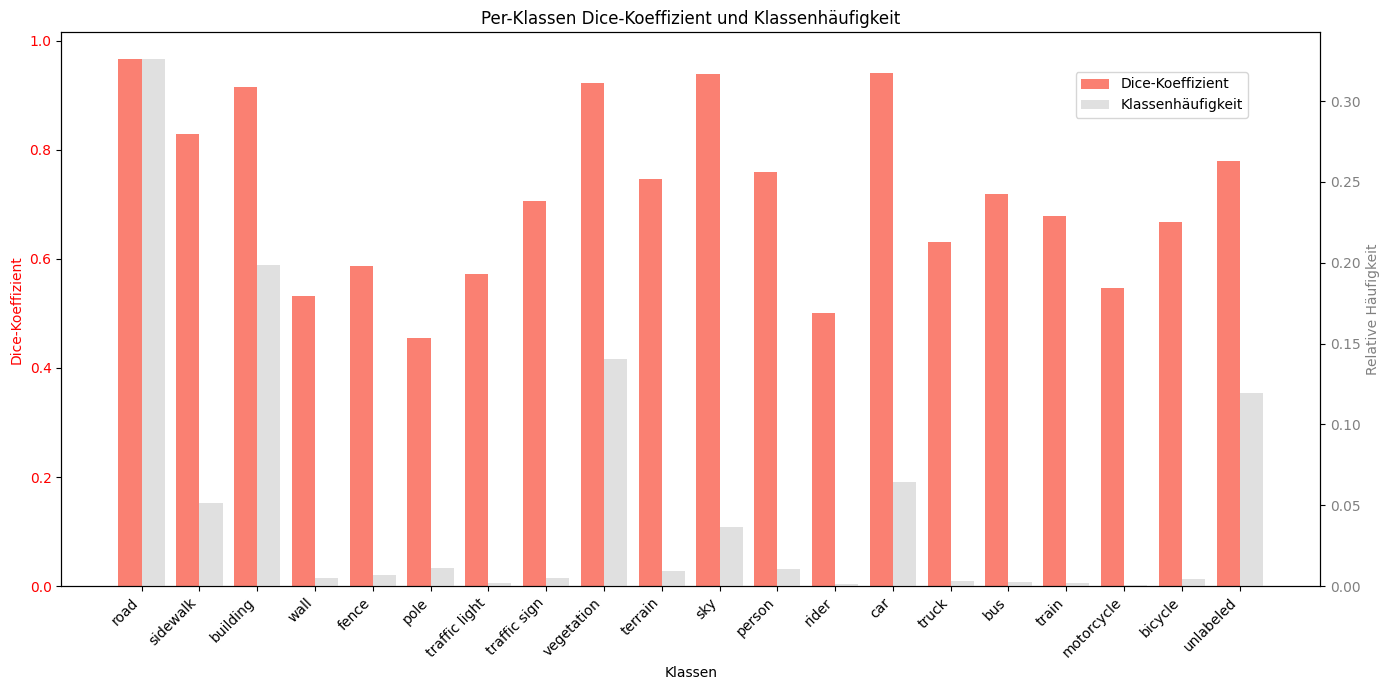


Gesamtmetriken Tabelle:
                Metric    Value
              Mean IoU 0.586330
   Mean Pixel Accuracy 0.732549
Frequency Weighted IoU 0.824669
 Mean Dice Coefficient 0.719698


In [54]:
# Metrik Test Dataensatz mit Klassen Anteil
from tqdm import tqdm

# Anzahl der Klassen
num_classes = model.num_classes

# Klassennamen definieren
class_names = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic light', 'traffic sign', 'vegetation', 'terrain',
    'sky', 'person', 'rider', 'car', 'truck', 'bus',
    'train', 'motorcycle', 'bicycle', 'unlabeled'
]

# Konfusionsmatrix und Klassenhäufigkeit initialisieren
confusion_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int64)
class_pixel_counts = torch.zeros(num_classes, dtype=torch.int64)

# Modell in den Evaluationsmodus setzen
model.model.eval()

# Evaluierung starten
with torch.no_grad():
    for i in tqdm(range(len(k_fold_dataset.test_dataset)), desc='Evaluating'):
        # Bild und Annotation laden
        image, annotation = k_fold_dataset.test_dataset[i]
        
        # Inferenz durchführen
        output = model.inference(image)
        predicted = output.argmax(1).squeeze(0)
        
        # Konfusionsmatrix aktualisieren
        conf_matrix = compute_confusion_matrix(predicted.cpu(), annotation.cpu(), num_classes)
        confusion_matrix += conf_matrix
        
        # Häufigkeit der Klassen in der Annotation zählen
        for cls in range(num_classes):
            class_pixel_counts[cls] += torch.sum(annotation == cls)

# Relative Häufigkeit jeder Klasse berechnen
total_pixels = class_pixel_counts.sum()
class_frequencies = class_pixel_counts.float() / total_pixels

# Metriken berechnen
miou, per_class_iou = compute_miou(confusion_matrix)
mpa, per_class_pa = compute_mean_pixel_accuracy(confusion_matrix)
fwiou = compute_fwiou(confusion_matrix)
mean_dice, per_class_dice = compute_dice_coefficient(confusion_matrix)

# Gesamtmetriken anzeigen
print("Gesamtmetriken:")
print(f"Mean IoU: {miou:.4f}")
print(f"Mean Pixel Accuracy: {mpa:.4f}")
print(f"Frequency Weighted IoU: {fwiou:.4f}")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")

# Metriken und Frequenzen in NumPy-Arrays konvertieren
per_class_iou_np = per_class_iou.cpu().numpy()
per_class_pa_np = per_class_pa.cpu().numpy()
per_class_dice_np = per_class_dice.cpu().numpy()
class_frequencies_np = class_frequencies.cpu().numpy()

# Per-Klassen IoU mit Klassenhäufigkeit plotten
fig, ax1 = plt.subplots(figsize=(14, 7))
bars1 = ax1.bar(np.arange(num_classes) - 0.2, per_class_iou_np, width=0.4, label='IoU', color='skyblue', align='center')
ax1.set_xlabel('Klassen')
ax1.set_ylabel('IoU-Wert', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(np.arange(num_classes))
ax1.set_xticklabels(class_names, rotation=45, ha='right')

ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(num_classes) + 0.2, class_frequencies_np, width=0.4, label='Klassenhäufigkeit', color='lightgray', alpha=0.7, align='center')
ax2.set_ylabel('Relative Häufigkeit', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Per-Klassen IoU und Klassenhäufigkeit')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()

# Per-Klassen Pixel Accuracy mit Klassenhäufigkeit plotten
fig, ax1 = plt.subplots(figsize=(14, 7))
bars1 = ax1.bar(np.arange(num_classes) - 0.2, per_class_pa_np, width=0.4, label='Pixel Accuracy', color='lightgreen', align='center')
ax1.set_xlabel('Klassen')
ax1.set_ylabel('Pixel Accuracy', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xticks(np.arange(num_classes))
ax1.set_xticklabels(class_names, rotation=45, ha='right')

ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(num_classes) + 0.2, class_frequencies_np, width=0.4, label='Klassenhäufigkeit', color='lightgray', alpha=0.7, align='center')
ax2.set_ylabel('Relative Häufigkeit', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Per-Klassen Pixel Accuracy und Klassenhäufigkeit')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()

# Per-Klassen Dice-Koeffizient mit Klassenhäufigkeit plotten
fig, ax1 = plt.subplots(figsize=(14, 7))
bars1 = ax1.bar(np.arange(num_classes) - 0.2, per_class_dice_np, width=0.4, label='Dice-Koeffizient', color='salmon', align='center')
ax1.set_xlabel('Klassen')
ax1.set_ylabel('Dice-Koeffizient', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(np.arange(num_classes))
ax1.set_xticklabels(class_names, rotation=45, ha='right')

ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(num_classes) + 0.2, class_frequencies_np, width=0.4, label='Klassenhäufigkeit', color='lightgray', alpha=0.7, align='center')
ax2.set_ylabel('Relative Häufigkeit', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Per-Klassen Dice-Koeffizient und Klassenhäufigkeit')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()

# Gesamtmetriken in einer Tabelle darstellen
metrics_data = {
    'Metric': ['Mean IoU', 'Mean Pixel Accuracy', 'Frequency Weighted IoU', 'Mean Dice Coefficient'],
    'Value': [miou, mpa, fwiou, mean_dice]
}

metrics_df = pd.DataFrame(metrics_data)
print("\nGesamtmetriken Tabelle:")
print(metrics_df.to_string(index=False))


Evaluating: 100%|██████████| 695/695 [01:08<00:00, 10.13it/s]


Gesamtmetriken:
Mean IoU: 0.586330
Mean Pixel Accuracy: 0.732549
Frequency Weighted IoU: 0.824669
Mean Dice Coefficient: 0.719698

Per-Klassen Metriken:
Klasse                      IoU       Pixel Acc      Dice-Koeff      Häufigkeit
road                   0.936126        0.974717        0.967009        0.326177
sidewalk               0.708212        0.818291        0.829185        0.051227
building               0.842381        0.935365        0.914448        0.198513
wall                   0.362453        0.419838        0.532059        0.004969
fence                  0.416209        0.598257        0.587779        0.006731
pole                   0.294689        0.435633        0.455227        0.011175
traffic light          0.401585        0.478620        0.573044        0.001809
traffic sign           0.544991        0.677272        0.705494        0.004966
vegetation             0.856282        0.938017        0.922578        0.140351
terrain                0.595964        0.812307

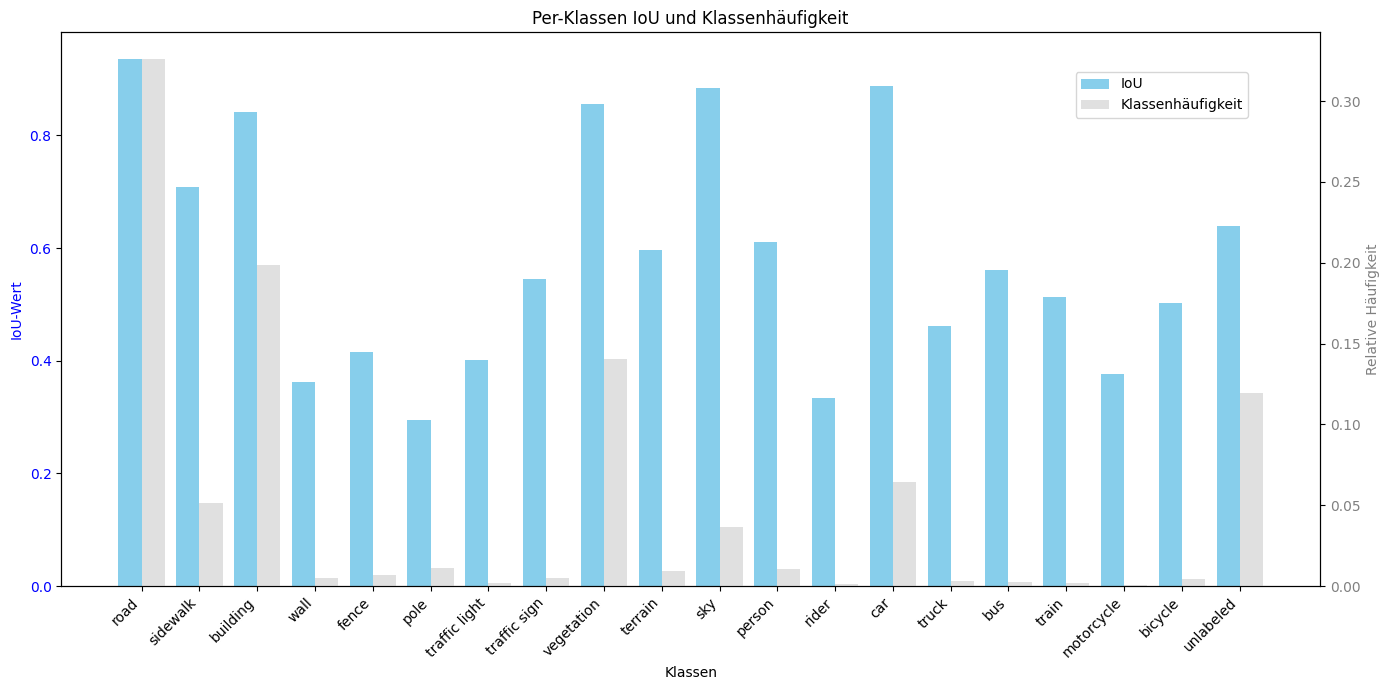

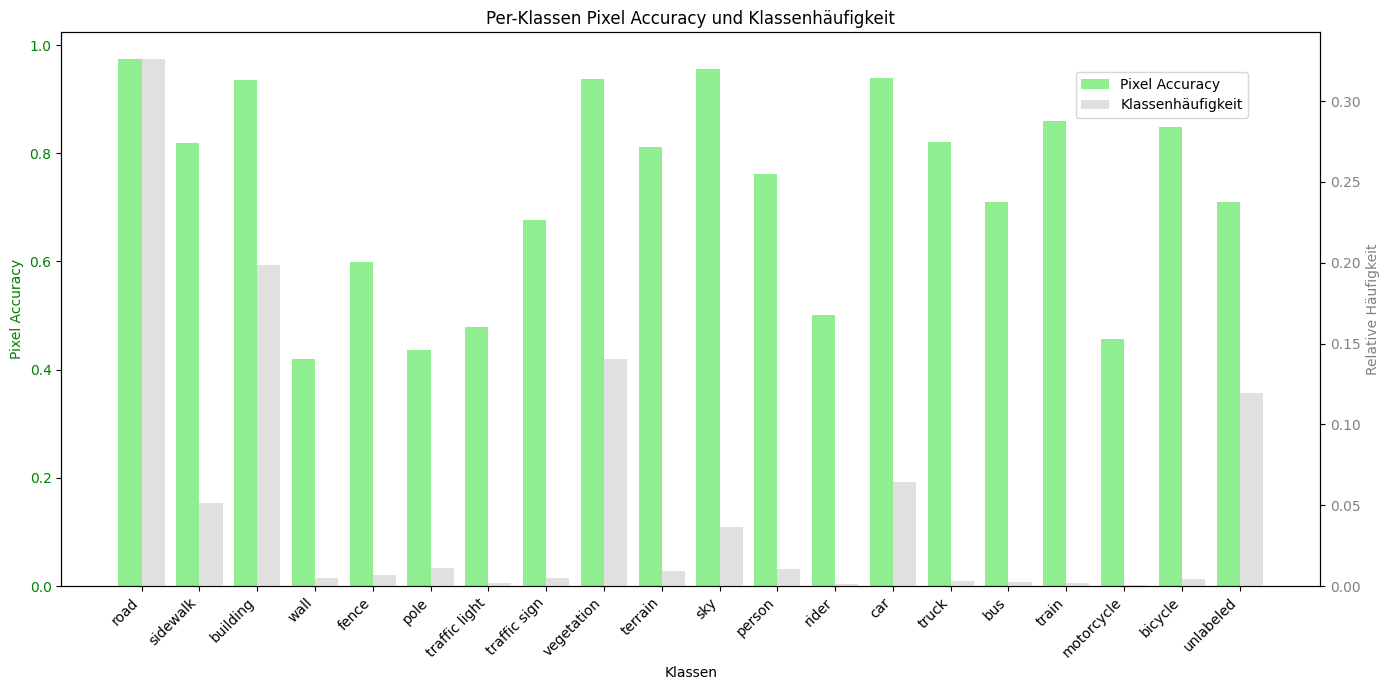

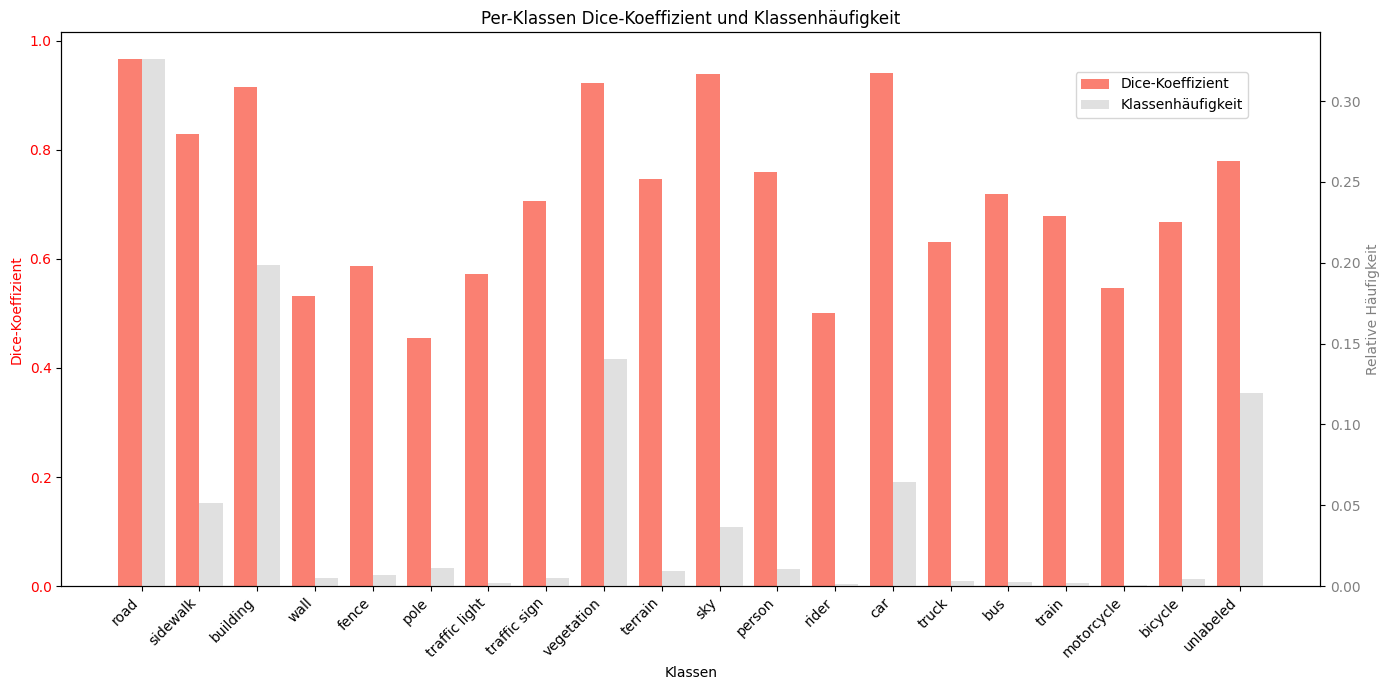


Gesamtmetriken Tabelle:
                Metric    Value
              Mean IoU 0.586330
   Mean Pixel Accuracy 0.732549
Frequency Weighted IoU 0.824669
 Mean Dice Coefficient 0.719698


In [55]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# Anzahl der Klassen
num_classes = model.num_classes

# Klassennamen definieren
class_names = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic light', 'traffic sign', 'vegetation', 'terrain',
    'sky', 'person', 'rider', 'car', 'truck', 'bus',
    'train', 'motorcycle', 'bicycle', 'unlabeled'
]

# Konfusionsmatrix und Klassenhäufigkeit initialisieren
confusion_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int64)
class_pixel_counts = torch.zeros(num_classes, dtype=torch.int64)

# Modell in den Evaluationsmodus setzen
model.model.eval()

# Evaluierung starten
with torch.no_grad():
    for i in tqdm(range(len(k_fold_dataset.test_dataset)), desc='Evaluating'):
        # Bild und Annotation laden
        image, annotation = k_fold_dataset.test_dataset[i]
        
        # Inferenz durchführen
        output = model.inference(image)
        predicted = output.argmax(1).squeeze(0)
        
        # Konfusionsmatrix aktualisieren
        conf_matrix = compute_confusion_matrix(predicted.cpu(), annotation.cpu(), num_classes)
        confusion_matrix += conf_matrix
        
        # Häufigkeit der Klassen in der Annotation zählen
        for cls in range(num_classes):
            class_pixel_counts[cls] += torch.sum(annotation == cls)

# Relative Häufigkeit jeder Klasse berechnen
total_pixels = class_pixel_counts.sum()
class_frequencies = class_pixel_counts.float() / total_pixels

# Metriken berechnen
miou, per_class_iou = compute_miou(confusion_matrix)
mpa, per_class_pa = compute_mean_pixel_accuracy(confusion_matrix)
fwiou = compute_fwiou(confusion_matrix)
mean_dice, per_class_dice = compute_dice_coefficient(confusion_matrix)

# Gesamtmetriken anzeigen
print("Gesamtmetriken:")
print(f"Mean IoU: {miou:.6f}")
print(f"Mean Pixel Accuracy: {mpa:.6f}")
print(f"Frequency Weighted IoU: {fwiou:.6f}")
print(f"Mean Dice Coefficient: {mean_dice:.6f}")

# Metriken und Frequenzen in NumPy-Arrays konvertieren
per_class_iou_np = per_class_iou.cpu().numpy()
per_class_pa_np = per_class_pa.cpu().numpy()
per_class_dice_np = per_class_dice.cpu().numpy()
class_frequencies_np = class_frequencies.cpu().numpy()

# Per-Klassen Metriken ausgeben
print("\nPer-Klassen Metriken:")
print("{:<20} {:>10} {:>15} {:>15} {:>15}".format("Klasse", "IoU", "Pixel Acc", "Dice-Koeff", "Häufigkeit"))
for idx in range(num_classes):
    print("{:<20} {:>10.6f} {:>15.6f} {:>15.6f} {:>15.6f}".format(
        class_names[idx],
        per_class_iou_np[idx],
        per_class_pa_np[idx],
        per_class_dice_np[idx],
        class_frequencies_np[idx]
    ))

# Per-Klassen IoU mit Klassenhäufigkeit plotten
fig, ax1 = plt.subplots(figsize=(14, 7))
bars1 = ax1.bar(np.arange(num_classes) - 0.2, per_class_iou_np, width=0.4, label='IoU', color='skyblue', align='center')
ax1.set_xlabel('Klassen')
ax1.set_ylabel('IoU-Wert', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(np.arange(num_classes))
ax1.set_xticklabels(class_names, rotation=45, ha='right')

ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(num_classes) + 0.2, class_frequencies_np, width=0.4, label='Klassenhäufigkeit', color='lightgray', alpha=0.7, align='center')
ax2.set_ylabel('Relative Häufigkeit', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Per-Klassen IoU und Klassenhäufigkeit')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()

# Per-Klassen Pixel Accuracy mit Klassenhäufigkeit plotten
fig, ax1 = plt.subplots(figsize=(14, 7))
bars1 = ax1.bar(np.arange(num_classes) - 0.2, per_class_pa_np, width=0.4, label='Pixel Accuracy', color='lightgreen', align='center')
ax1.set_xlabel('Klassen')
ax1.set_ylabel('Pixel Accuracy', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xticks(np.arange(num_classes))
ax1.set_xticklabels(class_names, rotation=45, ha='right')

ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(num_classes) + 0.2, class_frequencies_np, width=0.4, label='Klassenhäufigkeit', color='lightgray', alpha=0.7, align='center')
ax2.set_ylabel('Relative Häufigkeit', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Per-Klassen Pixel Accuracy und Klassenhäufigkeit')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()

# Per-Klassen Dice-Koeffizient mit Klassenhäufigkeit plotten
fig, ax1 = plt.subplots(figsize=(14, 7))
bars1 = ax1.bar(np.arange(num_classes) - 0.2, per_class_dice_np, width=0.4, label='Dice-Koeffizient', color='salmon', align='center')
ax1.set_xlabel('Klassen')
ax1.set_ylabel('Dice-Koeffizient', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(np.arange(num_classes))
ax1.set_xticklabels(class_names, rotation=45, ha='right')

ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(num_classes) + 0.2, class_frequencies_np, width=0.4, label='Klassenhäufigkeit', color='lightgray', alpha=0.7, align='center')
ax2.set_ylabel('Relative Häufigkeit', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Per-Klassen Dice-Koeffizient und Klassenhäufigkeit')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()

# Gesamtmetriken in einer Tabelle darstellen
metrics_data = {
    'Metric': ['Mean IoU', 'Mean Pixel Accuracy', 'Frequency Weighted IoU', 'Mean Dice Coefficient'],
    'Value': [miou, mpa, fwiou, mean_dice]
}

metrics_df = pd.DataFrame(metrics_data)
print("\nGesamtmetriken Tabelle:")
print(metrics_df.to_string(index=False))


Evaluating: 100%|██████████| 695/695 [01:09<00:00, 10.07it/s]



Per-Klassen Metriken:
Klasse                      IoU       Pixel Acc      Dice-Koeff      Häufigkeit
road                   0.936126        0.974717        0.967009        0.326177
sidewalk               0.708212        0.818291        0.829185        0.051227
building               0.842381        0.935365        0.914448        0.198513
wall                   0.362453        0.419838        0.532059        0.004969
fence                  0.416209        0.598257        0.587779        0.006731
pole                   0.294689        0.435633        0.455227        0.011175
traffic light          0.401585        0.478620        0.573044        0.001809
traffic sign           0.544991        0.677272        0.705494        0.004966
vegetation             0.856282        0.938017        0.922578        0.140351
terrain                0.595964        0.812307        0.746839        0.009396
sky                    0.884044        0.955700        0.938454        0.036572
person           

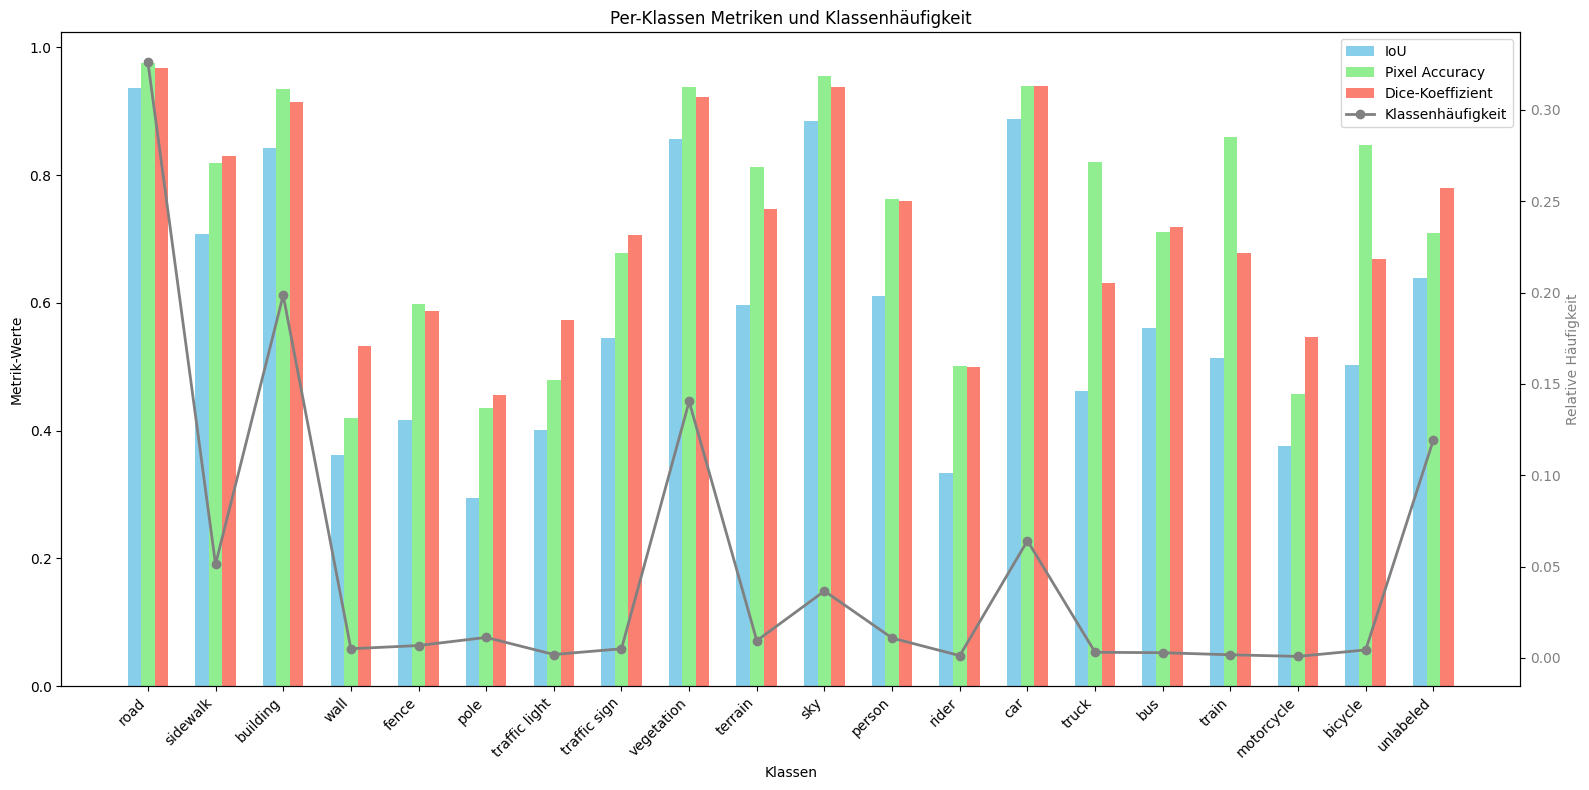


Gesamtmetriken Tabelle:
                Metric    Value
              Mean IoU 0.586330
   Mean Pixel Accuracy 0.732549
Frequency Weighted IoU 0.824669
 Mean Dice Coefficient 0.719698


In [56]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# Anzahl der Klassen
num_classes = model.num_classes

# Klassennamen definieren
class_names = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic light', 'traffic sign', 'vegetation', 'terrain',
    'sky', 'person', 'rider', 'car', 'truck', 'bus',
    'train', 'motorcycle', 'bicycle', 'unlabeled'
]

# Konfusionsmatrix und Klassenhäufigkeit initialisieren
confusion_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int64)
class_pixel_counts = torch.zeros(num_classes, dtype=torch.int64)

# Modell in den Evaluationsmodus setzen
model.model.eval()

# Evaluierung starten
with torch.no_grad():
    for i in tqdm(range(len(k_fold_dataset.test_dataset)), desc='Evaluating'):
        # Bild und Annotation laden
        image, annotation = k_fold_dataset.test_dataset[i]
        
        # Inferenz durchführen
        output = model.inference(image)
        predicted = output.argmax(1).squeeze(0)
        
        # Konfusionsmatrix aktualisieren
        conf_matrix = compute_confusion_matrix(predicted.cpu(), annotation.cpu(), num_classes)
        confusion_matrix += conf_matrix
        
        # Häufigkeit der Klassen in der Annotation zählen
        for cls in range(num_classes):
            class_pixel_counts[cls] += torch.sum(annotation == cls)

# Relative Häufigkeit jeder Klasse berechnen
total_pixels = class_pixel_counts.sum()
class_frequencies = class_pixel_counts.float() / total_pixels

# Metriken berechnen
miou, per_class_iou = compute_miou(confusion_matrix)
mpa, per_class_pa = compute_mean_pixel_accuracy(confusion_matrix)
fwiou = compute_fwiou(confusion_matrix)
mean_dice, per_class_dice = compute_dice_coefficient(confusion_matrix)

# Metriken und Frequenzen in NumPy-Arrays konvertieren
per_class_iou_np = per_class_iou.cpu().numpy()
per_class_pa_np = per_class_pa.cpu().numpy()
per_class_dice_np = per_class_dice.cpu().numpy()
class_frequencies_np = class_frequencies.cpu().numpy()

# Per-Klassen Metriken ausgeben
print("\nPer-Klassen Metriken:")
print("{:<20} {:>10} {:>15} {:>15} {:>15}".format("Klasse", "IoU", "Pixel Acc", "Dice-Koeff", "Häufigkeit"))
for idx in range(num_classes):
    print("{:<20} {:>10.6f} {:>15.6f} {:>15.6f} {:>15.6f}".format(
        class_names[idx],
        per_class_iou_np[idx],
        per_class_pa_np[idx],
        per_class_dice_np[idx],
        class_frequencies_np[idx]
    ))

# Zusammenführen aller Metriken in einem Diagramm
fig, ax1 = plt.subplots(figsize=(16, 8))

bar_width = 0.2
index = np.arange(num_classes)

# Balken für IoU, Pixel Accuracy und Dice-Koeffizient
bars1 = ax1.bar(index - bar_width, per_class_iou_np, bar_width, label='IoU', color='skyblue')
bars2 = ax1.bar(index, per_class_pa_np, bar_width, label='Pixel Accuracy', color='lightgreen')
bars3 = ax1.bar(index + bar_width, per_class_dice_np, bar_width, label='Dice-Koeffizient', color='salmon')

# Achsenbeschriftungen für die linke y-Achse
ax1.set_xlabel('Klassen')
ax1.set_ylabel('Metrik-Werte')
ax1.set_xticks(index)
ax1.set_xticklabels(class_names, rotation=45, ha='right')

# Zweite y-Achse für Klassenhäufigkeit
ax2 = ax1.twinx()
line = ax2.plot(index, class_frequencies_np, label='Klassenhäufigkeit', color='gray', marker='o', linewidth=2)

ax2.set_ylabel('Relative Häufigkeit', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Legenden zusammenführen
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Titel und Layout
plt.title('Per-Klassen Metriken und Klassenhäufigkeit')
plt.tight_layout()
plt.show()

# Gesamtmetriken in einer Tabelle darstellen
metrics_data = {
    'Metric': ['Mean IoU', 'Mean Pixel Accuracy', 'Frequency Weighted IoU', 'Mean Dice Coefficient'],
    'Value': [miou, mpa, fwiou, mean_dice]
}

metrics_df = pd.DataFrame(metrics_data)
print("\nGesamtmetriken Tabelle:")
print(metrics_df.to_string(index=False))


Evaluating: 100%|██████████| 695/695 [01:08<00:00, 10.12it/s]



Per-Klassen Metriken:
Klasse                      IoU       Pixel Acc      Dice-Koeff      Häufigkeit
road                   0.936126        0.974717        0.967009        0.326177
sidewalk               0.708212        0.818291        0.829185        0.051227
building               0.842381        0.935365        0.914448        0.198513
wall                   0.362453        0.419838        0.532059        0.004969
fence                  0.416209        0.598257        0.587779        0.006731
pole                   0.294689        0.435633        0.455227        0.011175
traffic light          0.401585        0.478620        0.573044        0.001809
traffic sign           0.544991        0.677272        0.705494        0.004966
vegetation             0.856282        0.938017        0.922578        0.140351
terrain                0.595964        0.812307        0.746839        0.009396
sky                    0.884044        0.955700        0.938454        0.036572
person           

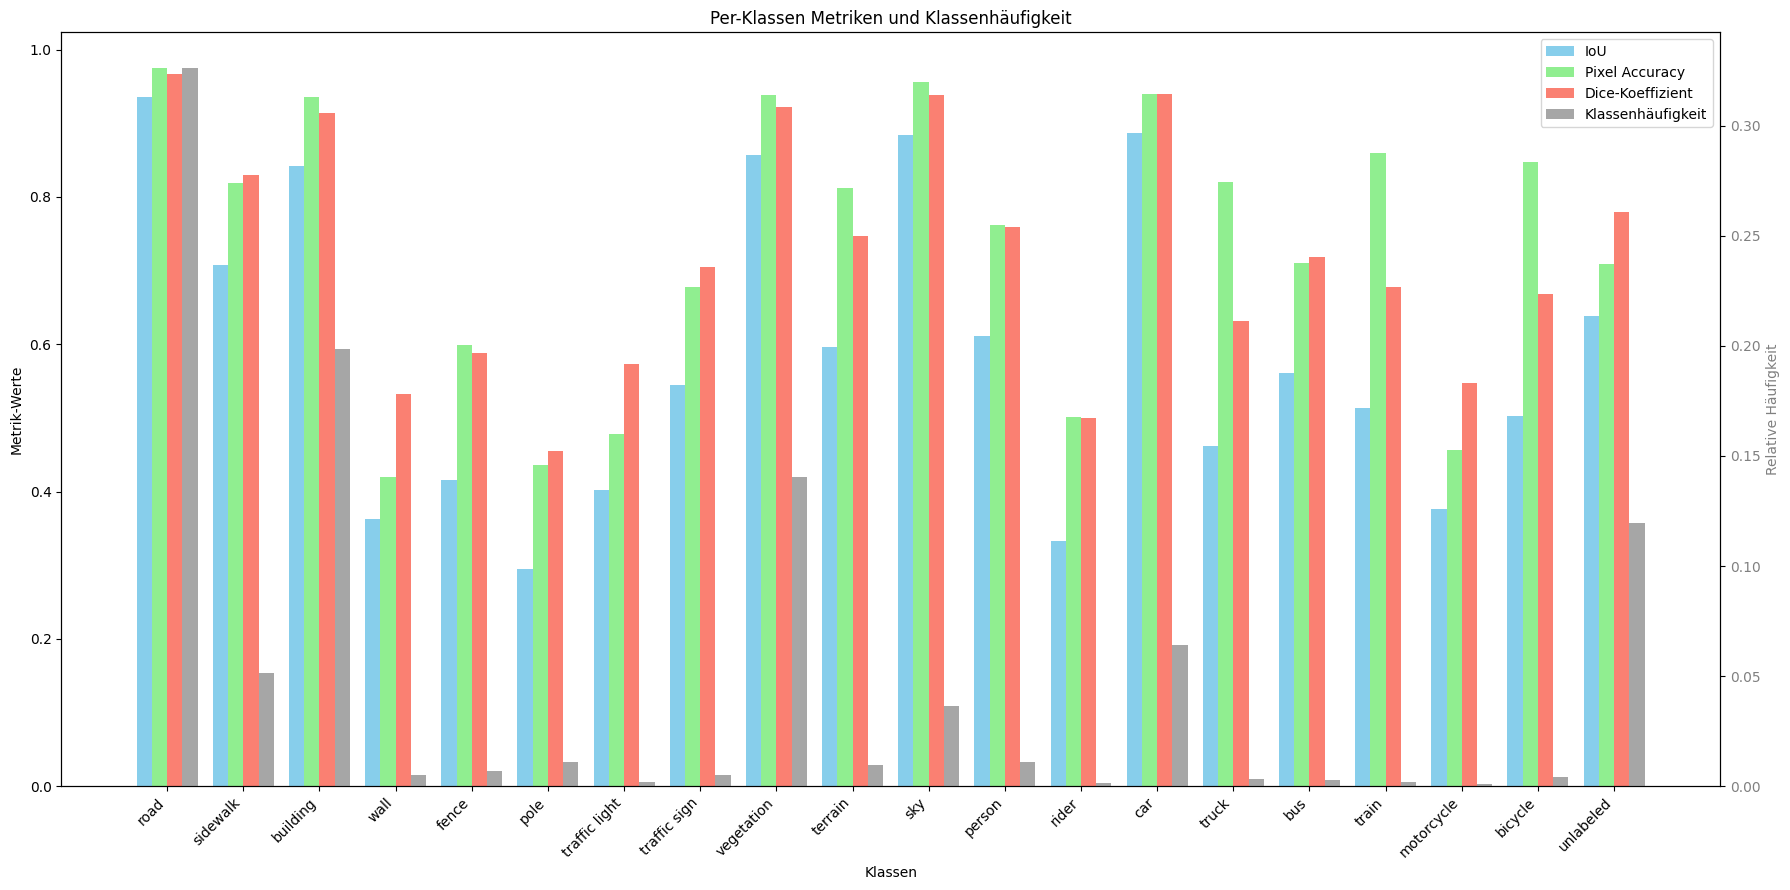


Gesamtmetriken Tabelle:
                Metric    Value
              Mean IoU 0.586330
   Mean Pixel Accuracy 0.732549
Frequency Weighted IoU 0.824669
 Mean Dice Coefficient 0.719698


In [57]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# Anzahl der Klassen
num_classes = model.num_classes

# Klassennamen definieren
class_names = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic light', 'traffic sign', 'vegetation', 'terrain',
    'sky', 'person', 'rider', 'car', 'truck', 'bus',
    'train', 'motorcycle', 'bicycle', 'unlabeled'
]

# Konfusionsmatrix und Klassenhäufigkeit initialisieren
confusion_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int64)
class_pixel_counts = torch.zeros(num_classes, dtype=torch.int64)

# Modell in den Evaluationsmodus setzen
model.model.eval()

# Evaluierung starten
with torch.no_grad():
    for i in tqdm(range(len(k_fold_dataset.test_dataset)), desc='Evaluating'):
        # Bild und Annotation laden
        image, annotation = k_fold_dataset.test_dataset[i]
        
        # Inferenz durchführen
        output = model.inference(image)
        predicted = output.argmax(1).squeeze(0)
        
        # Konfusionsmatrix aktualisieren
        conf_matrix = compute_confusion_matrix(predicted.cpu(), annotation.cpu(), num_classes)
        confusion_matrix += conf_matrix
        
        # Häufigkeit der Klassen in der Annotation zählen
        for cls in range(num_classes):
            class_pixel_counts[cls] += torch.sum(annotation == cls)

# Relative Häufigkeit jeder Klasse berechnen
total_pixels = class_pixel_counts.sum()
class_frequencies = class_pixel_counts.float() / total_pixels

# Metriken berechnen
miou, per_class_iou = compute_miou(confusion_matrix)
mpa, per_class_pa = compute_mean_pixel_accuracy(confusion_matrix)
fwiou = compute_fwiou(confusion_matrix)
mean_dice, per_class_dice = compute_dice_coefficient(confusion_matrix)

# Metriken und Frequenzen in NumPy-Arrays konvertieren
per_class_iou_np = per_class_iou.cpu().numpy()
per_class_pa_np = per_class_pa.cpu().numpy()
per_class_dice_np = per_class_dice.cpu().numpy()
class_frequencies_np = class_frequencies.cpu().numpy()

# Per-Klassen Metriken ausgeben
print("\nPer-Klassen Metriken:")
print("{:<20} {:>10} {:>15} {:>15} {:>15}".format("Klasse", "IoU", "Pixel Acc", "Dice-Koeff", "Häufigkeit"))
for idx in range(num_classes):
    print("{:<20} {:>10.6f} {:>15.6f} {:>15.6f} {:>15.6f}".format(
        class_names[idx],
        per_class_iou_np[idx],
        per_class_pa_np[idx],
        per_class_dice_np[idx],
        class_frequencies_np[idx]
    ))

# Zusammenführen aller Metriken in einem Diagramm
fig, ax1 = plt.subplots(figsize=(18, 9))

bar_width = 0.2
index = np.arange(num_classes)

# Balken für IoU, Pixel Accuracy, Dice-Koeffizient und Klassenhäufigkeit
bars1 = ax1.bar(index - 1.5 * bar_width, per_class_iou_np, bar_width, label='IoU', color='skyblue')
bars2 = ax1.bar(index - 0.5 * bar_width, per_class_pa_np, bar_width, label='Pixel Accuracy', color='lightgreen')
bars3 = ax1.bar(index + 0.5 * bar_width, per_class_dice_np, bar_width, label='Dice-Koeffizient', color='salmon')

# Sekundäre y-Achse für Klassenhäufigkeit
ax2 = ax1.twinx()
bars4 = ax2.bar(index + 1.5 * bar_width, class_frequencies_np, bar_width, label='Klassenhäufigkeit', color='gray', alpha=0.7)

# Achsenbeschriftungen
ax1.set_xlabel('Klassen')
ax1.set_ylabel('Metrik-Werte')
ax2.set_ylabel('Relative Häufigkeit', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# x-Achsen-Ticks
ax1.set_xticks(index)
ax1.set_xticklabels(class_names, rotation=45, ha='right')

# Legenden zusammenführen
bars = [bars1, bars2, bars3, bars4]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc='upper right')

# Titel und Layout
plt.title('Per-Klassen Metriken und Klassenhäufigkeit')
plt.tight_layout()
plt.show()

# Gesamtmetriken in einer Tabelle darstellen
metrics_data = {
    'Metric': ['Mean IoU', 'Mean Pixel Accuracy', 'Frequency Weighted IoU', 'Mean Dice Coefficient'],
    'Value': [miou, mpa, fwiou, mean_dice]
}

metrics_df = pd.DataFrame(metrics_data)
print("\nGesamtmetriken Tabelle:")
print(metrics_df.to_string(index=False))
